In [1]:
from NeurGrad import initialize_model_and_tokenizer
from NeurGrad.neurgrad import NeurGrad
from NeurGrad import get_model_type

model, tokenizer = initialize_model_and_tokenizer("llama3.2-3b-it")
ngrad = NeurGrad(model=model, tokenizer=tokenizer, model_type=get_model_type("llama3.2-3b-it"))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
prompt = "Predict the [MASK] in each sentence in one word.\nQ: [MASK] recognizes Royaume de Belgique as its official language.\nA:"
gt = "French"
negs = ngrad.get_scores(prompt, gt, attribution_method="gradient")

In [3]:
import torch

_, all_negs, all_acts = ngrad.get_negs_in_batch([prompt], [gt], act_threshold=0, return_cg=False)
negs, neurons = ngrad.get_sampled_neurons(all_negs, num_neurons=10)
# pos_neurons, neg_neurons = ngrad.get_pos_neg_neurons(grads, neurons)

acts = []
for _acts, _indices in zip(all_acts, neurons):
    row_indices, col_indices = _indices.unbind(dim=1)
    acts.append(_acts[row_indices, col_indices])
acts = torch.stack(acts)


In [4]:
from typing import List, Tuple

def measure_change(result_dict, verbose=False):
    pred_changed = result_dict['after']['argmax_completion'] == result_dict['before']['argmax_completion']
    prob_changed = result_dict['after']['gt_prob'] - result_dict['before']['gt_prob']
    if verbose:
        print(f"{result_dict['before']['argmax_completion']}, {result_dict['before']['gt_prob']:.2%} --> {result_dict['after']['gt_prob']:.2%}")
    return pred_changed, prob_changed

def neuron_intervention(
        ngrad: NeurGrad, 
        prompt: str, gt: str, 
        pos_neurons: List[Tuple[str, str]], 
        neg_neurons: List[Tuple[str, str]], 
        volume: float):
    ## NOTE: The polarity of neurons is considered for neuron intervention. 
    ## For positive neurons, suppression operation reduces the activation, while enhancement increases it.
    ## For negative neurons, suppression operation increases the activation, while enhancement decreases it.
    suppress, _ = ngrad.suppress_knowledge([prompt], [gt], pos_neurons=pos_neurons, neg_neurons=neg_neurons, change_ratio=None, change_volume=volume)
    enhance, _  = ngrad.enhance_knowledge([prompt], [gt], pos_neurons=pos_neurons, neg_neurons=neg_neurons, change_ratio=None, change_volume=volume)
    _, diff_suppress  = measure_change(suppress[0])
    _, diff_enhance   = measure_change(enhance[0])
    neurons = list(pos_neurons) + list(neg_neurons)
    return {
        "prompt": prompt,
        "ground_truth": gt,
        "neuron": neurons,
        "volume":   volume,
        "org_prob": suppress[0]['before']['gt_prob'],
        "diff_suppress": diff_suppress,
        "diff_enhance": diff_enhance,
    }
    

In [5]:
import numpy as np
from tqdm import tqdm
import pandas as pd

max_volume = 2
volume_granu = 0.1
results = []
for act, neg, neuron in tqdm(zip(acts[0], negs[0], neurons[0])):
    pos_neurons, neg_neurons = ([tuple(neuron.tolist())], []) if neg > 0 else ([], [tuple(neuron.tolist())])
    for volume in np.arange(0, int(max_volume/volume_granu)) + 1:
        result = neuron_intervention(
            ngrad, prompt, gt, 
            pos_neurons=pos_neurons, neg_neurons=neg_neurons, 
            volume=volume * volume_granu)
        result['activation'] = act.item()
        result['gradient'] = neg.item()
        results.append(result)
df = pd.DataFrame(results)
df['neuron'] = df['neuron'].apply(lambda x: list(tuple(neuron) for neuron in x)[0])

10it [00:18,  1.84s/it]


In [6]:
results[0]

{'prompt': 'Predict the [MASK] in each sentence in one word.\nQ: [MASK] recognizes Royaume de Belgique as its official language.\nA:',
 'ground_truth': 'French',
 'neuron': [(20, 3781)],
 'volume': 0.1,
 'org_prob': 0.00027386524016037583,
 'diff_suppress': -1.3472163118422031e-07,
 'diff_enhance': 1.3509998098015785e-07,
 'activation': 0.2464490532875061,
 'gradient': -1.3678517234438914e-06}

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def calculate_neg(delta_volumes, delta_probs):
    model = LinearRegression(fit_intercept=False)
    model.fit(delta_volumes, delta_probs)
    neg = model.coef_[0]
    return neg

def fit_and_plot(delta_volumes, delta_probs, neurgrad_estimation, neg, corr, title):
    x = delta_volumes
    y = delta_probs
    plt.figure(figsize=(4,3))

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = abs(neg) * x_fit

    # Plot the original data points
    plt.scatter(x, y, color='red')
    plt.plot(x_fit, y_fit, color='blue', label="Linear Fit", linewidth=2)
    plt.text(
        0.05, 0.95, f'Correlation: {corr:.2f}', 
        transform=plt.gca().transAxes, 
        fontsize=10, verticalalignment='top')
    plt.text(
        0.05, 0.88, f'NeurGrad: {neurgrad_estimation:.2e}', 
        transform=plt.gca().transAxes, 
        fontsize=10, verticalalignment='top')
    plt.text(
        0.05, 0.81, f'NEG: {neg:.2e}', 
        transform=plt.gca().transAxes, 
        fontsize=10, verticalalignment='top')
    
    # Add labels and a legend
    plt.xlabel('Activation Shifts')
    plt.ylabel('Output Shifts')
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()

def measure_linearity(x, y) -> float:
    if np.all(x == 0) or np.all(y == 0):
        return 0
    assert len(set(x)) == len(x), f"{len(set(x))}, {len(x)}"
    p, _ = pearsonr(x, y)
    return p

def return_delta_volumes_probs(df, plot=False):
    assert len(df['neuron'].apply(tuple).unique()) == 1
    assert len(df['gradient'].apply(float).unique()) == 1
    neurgrad_estimation = df['gradient'].iloc[0]
    volume = np.asarray(df["volume"].tolist())
    delta_volumes = np.concatenate((np.flip(volume) * -1, volume))
    enhance = np.asarray(df["diff_enhance"].tolist())
    suppress = np.asarray(df["diff_suppress"].tolist())
    delta_probs = np.concatenate((np.flip(suppress), enhance))
    corr = measure_linearity(delta_volumes, delta_probs)
    neg_abs = calculate_neg(delta_volumes.reshape(-1, 1) , delta_probs.reshape(-1, 1) )
    neg = neg_abs * np.sign(neurgrad_estimation)
    if plot:
        fit_and_plot(
            delta_volumes, 
            delta_probs, 
            neurgrad_estimation=neurgrad_estimation,
            neg=neg.item(),
            corr=corr,
            title="Neuron intervention on the neuron: " + str(df['neuron'].iloc[0])) 
    return delta_volumes, delta_probs

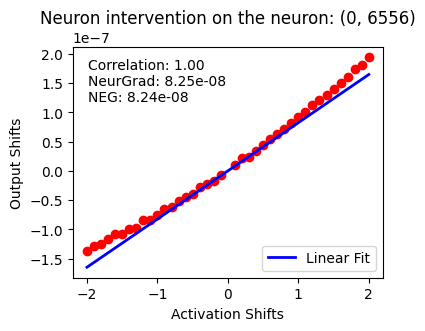

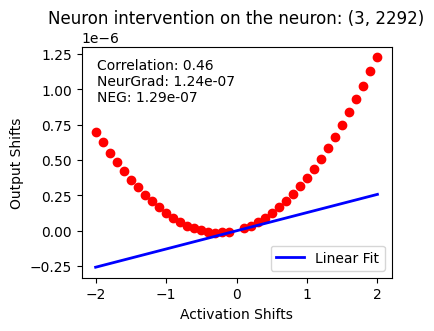

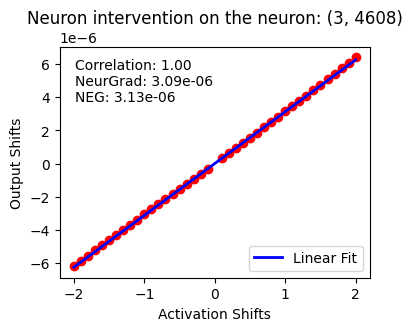

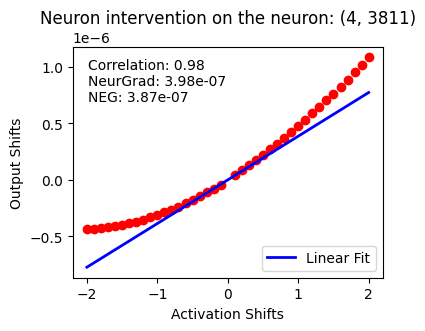

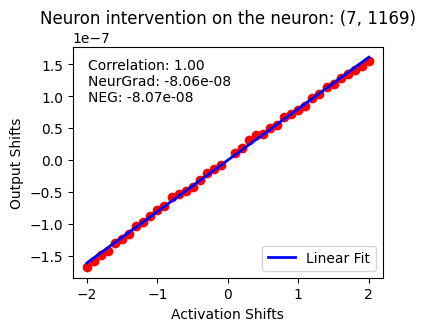

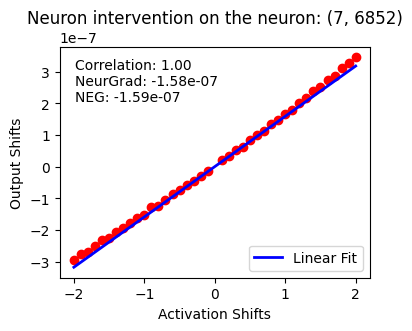

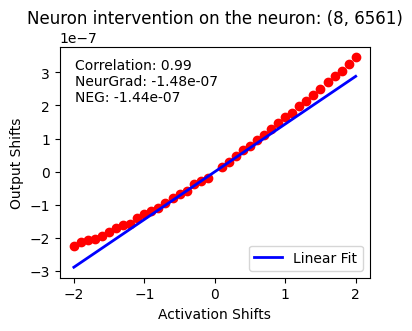

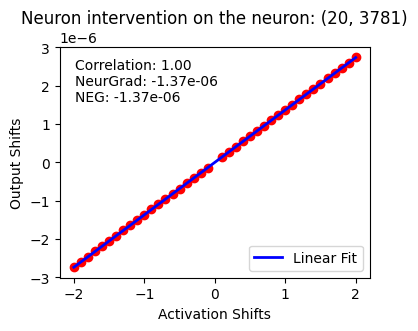

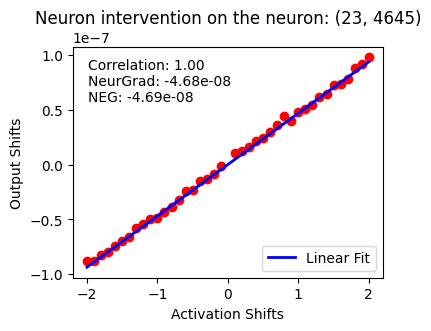

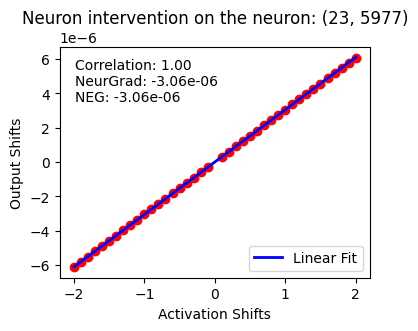

In [10]:
corrs = []
negs = []
for neuron, sdf in df.groupby(by='neuron'):
    delta_volumes, delta_probs = return_delta_volumes_probs(sdf, plot=True)
    negs.append(abs(sdf['gradient'].tolist()[0]))